# Community

Here we quickly show an example of the package applied to the some metabolic models as before. We construct some community models and demonstrate some of the available tools for analysis.

In [1]:
from ncmw.utils import get_models
from ncmw.community import BagOfReactionsModel, ShuttleCommunityModel
from ncmw.setup_models import set_default_configs_and_snm3_medium
models = get_models("models")
for i in range(len(models)):
    models[i] = set_default_configs_and_snm3_medium(models[i])

## Bag of reaction model

This very simple approach models the community as union of all reactions and metabolites of it's members. So let's first consider this approach:

In [2]:
bag_model = BagOfReactionsModel(models)

In [4]:
_, growths, _ = bag_model.optimize()
for m, g in zip(models, growths):
    print(f"{m.id.split(sep='_')[0]} achives {g} biomass rate")

CarveMe achives 0.0 biomass rate
himodel achives 0.0 biomass rate
Staphylococcus achives 7.1101761769386655 biomass rate
DP achives 0.0 biomass rate
iYS854 achives 0.0 biomass rate


Mh, so as we can see the maximum growth rate for the community is achived if Staphylooccus outcompetes all other species. This may seems unrealistic. One think we can do is to "enforce" that any member of the comunity must grow at leat 10% of the total growth rate. So lets do this.

In [11]:
_, growths, _ = bag_model.optimize(enforce_survival=0.1)
for m, g in zip(models, growths):
    print(f"{m.id.split(sep='_')[0]} achives {g} biomass rate")

CarveMe achives 0.1306552884366914 biomass rate
himodel achives 6.010143268087804 biomass rate
Staphylococcus achives 0.1306552884366914 biomass rate
DP achives 0.1306552884366914 biomass rate
iYS854 achives 0.1306552884366914 biomass rate


Intestingly suddenly himodel achives most growth. Unforunatly with the BagOfReactions we cannot analyze the interactions more deeply. So lets look at the ShuttleCommunityModel.

## ShuttleCommunityModel

Here any community member is seperated in own compartments, but they can interact over an external environment through so called "shuttle reactions".

In [25]:
model = ShuttleCommunityModel(models)

In [31]:
_, growths, _ = model.optimize()
for m, g in zip(models, growths):
    print(f"{m.id.split(sep='_')[0]} achives {g} biomass rate")

CarveMe achives 0.051665019814527126 biomass rate
himodel achives 0.6220373234175469 biomass rate
Staphylococcus achives 0.03595262970433371 biomass rate
DP achives 0.13562384271818156 biomass rate
iYS854 achives 5.020210990276516 biomass rate


In [12]:
from ncmw.visualization import plot_pairwise_growth_relation_per_weight, plot_community_interaction, plot_community_summary, plot_community_uptake_graph, plot_species_interaction

## Pairwise community interaction

Here we plot the growth of each model, given the weight $\alpha$ (and $1-\alpha$ respectively). This shows e.g. at which weight the community is balanced between two species.

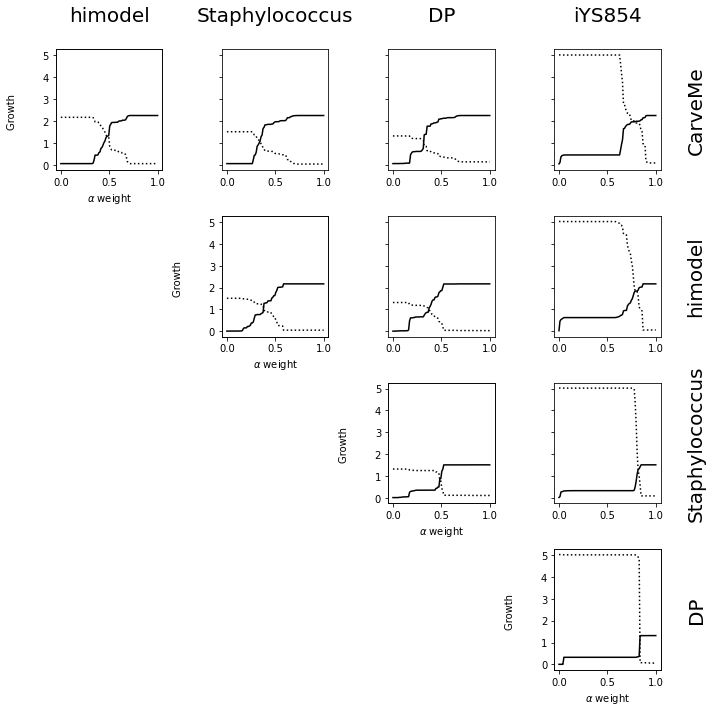

In [6]:
_ = plot_pairwise_growth_relation_per_weight(model)

## Community summary

Lets look on the flux summary for the community. In the ShuttleCommunityModel all models have their own reactions and thus we can distinguish which metabolites are consumed/produced by which species.

Objective:  5.865489805931107
CarveMe_SNM_gapfilled_model :  0.05166501981452698  with weights  1.0
himodel :  0.6220373234175482  with weights  1.0
Staphylococcus_epidermidis_ATCC_12228 :  0.03595262970433373  with weights  1.0
DP_83VPs_KB5 :  0.13562384271818173  with weights  1.0
iYS854 :  5.020210990276516  with weights  1.0


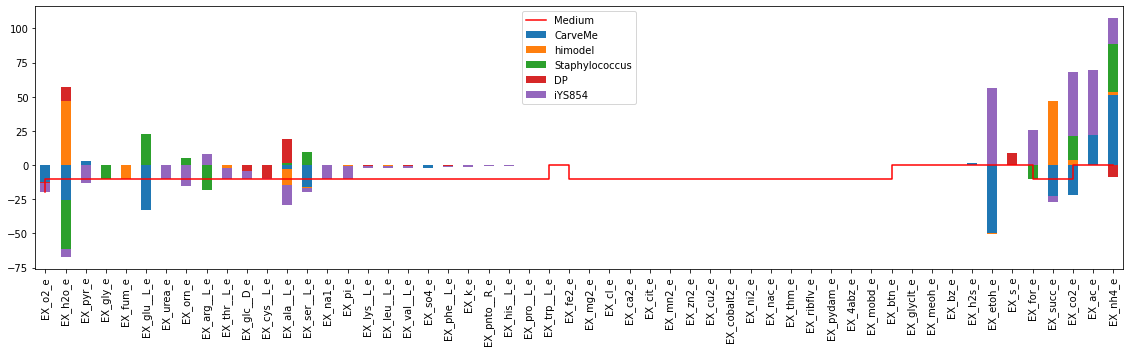

In [15]:
summary = model.summary()
f = plot_community_summary(model, summary)

This plot now actually contains most of the information. The red line shows the medium, everythink below the red line must be provide by other community members indicating a positive interaction between this species see e.g. EX_h20_e. That's cool, but we can visualize it more explicitly.

## Community interaction

Here we plot the internal exchanges between the community members. These show which metabolites are not provided by the medium but obtained from other community members.

c:\users\manug\desktop\ncmw projects\ncmw\ncmw\community\community_analysis.py:95: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(df.columns[-1], 1)


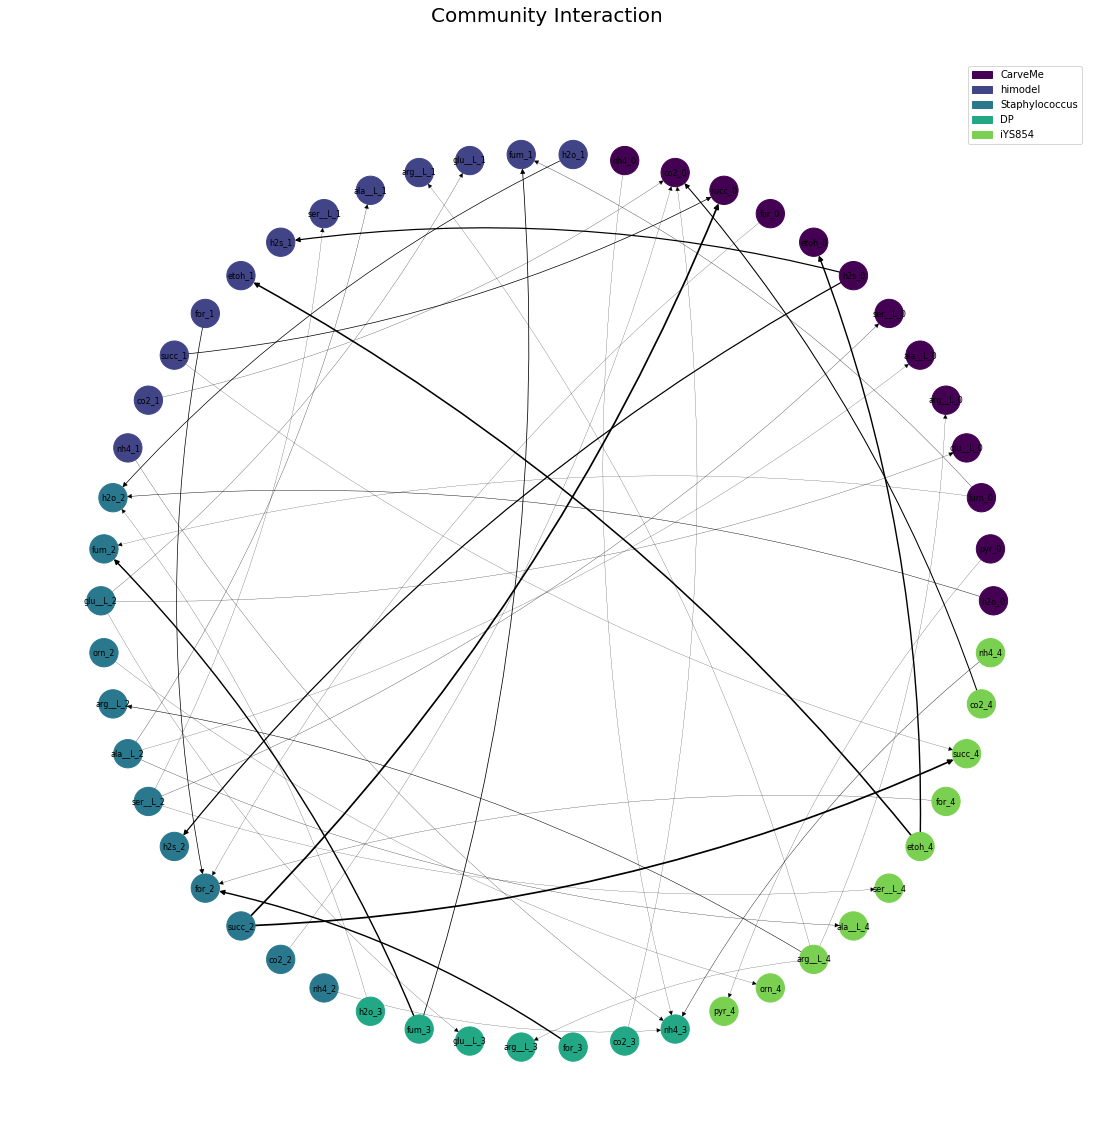

In [45]:
fig = plot_community_interaction(model, summary)

Equivalently we can now also illustrate which metabolites are actually taken from the medium.

C:\Users\manug\.conda\envs\ncmw\lib\site-packages\matplotlib\cbook\__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


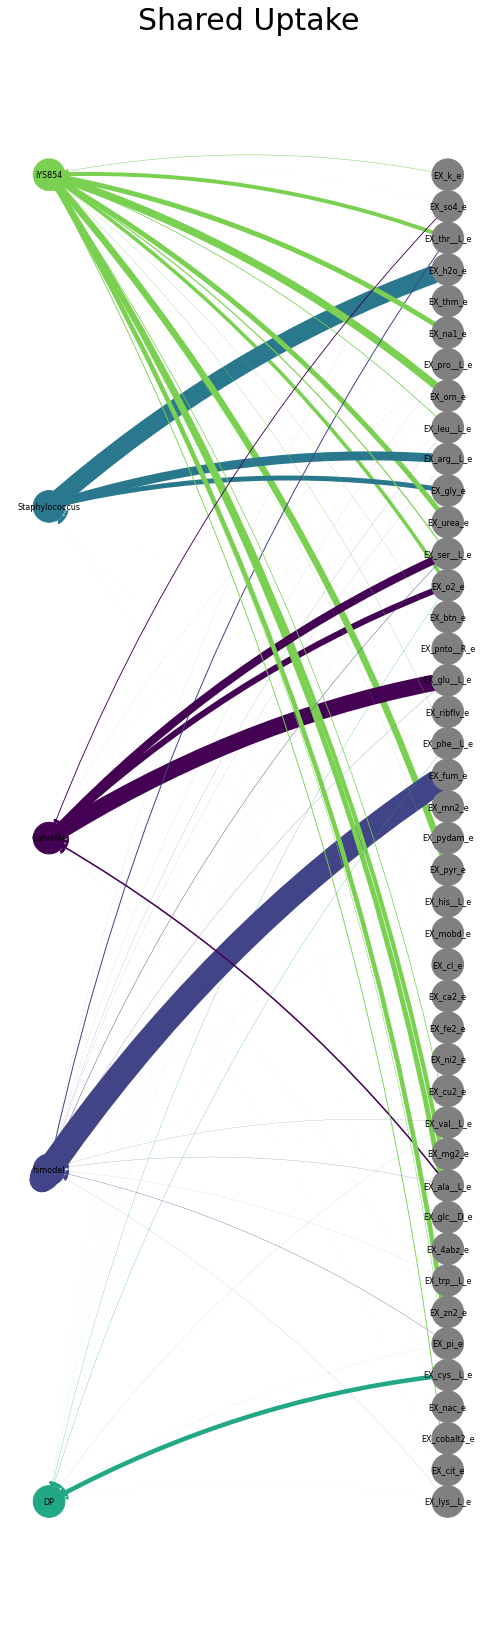

In [46]:
f = plot_community_uptake_graph(model, summary)

This may be a bit growded. So we can use this invormation to compute a "species interactions score". By doing so we arive at following plot:

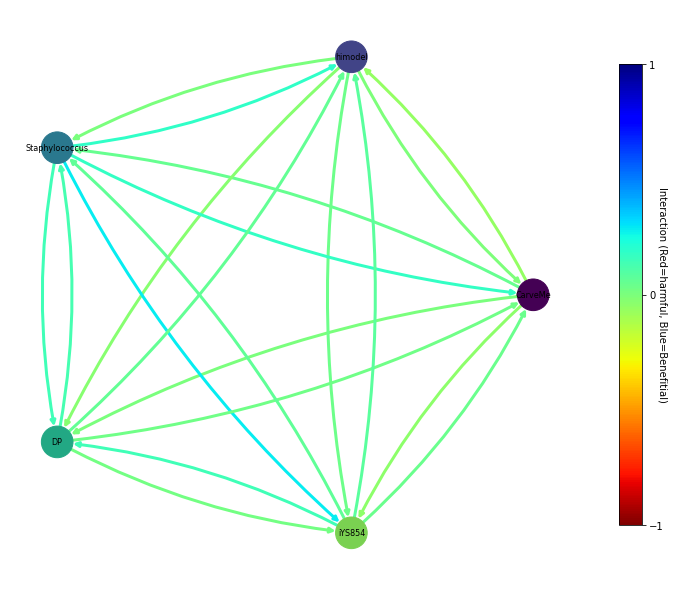

In [17]:
f = plot_species_interaction(model, summary)

On this rich media, we mostly observe neutral/positive interactions. Within the workflow we also compute a COMPM, meant to induce a competitive behaviour i.e. by reducing the medium such that any uptake of an other species will lower the growth.

## Cooperative tradeoff

We can see that still one of the models dominates the community. One way to obtain a more "balanced" community growth is to enable cooperative tradeoff. This will lead to a suboptimal community growth but will have a more balanced individual growth.

Objective:  2.3461959223724427
CarveMe_SNM_gapfilled_model :  0.46923918447448837  with weights  1.0
himodel :  0.4692391844744887  with weights  1.0
Staphylococcus_epidermidis_ATCC_12228 :  0.46923918447448854  with weights  1.0
DP_83VPs_KB5 :  0.46923918447448854  with weights  1.0
iYS854 :  0.46923918447448865  with weights  1.0


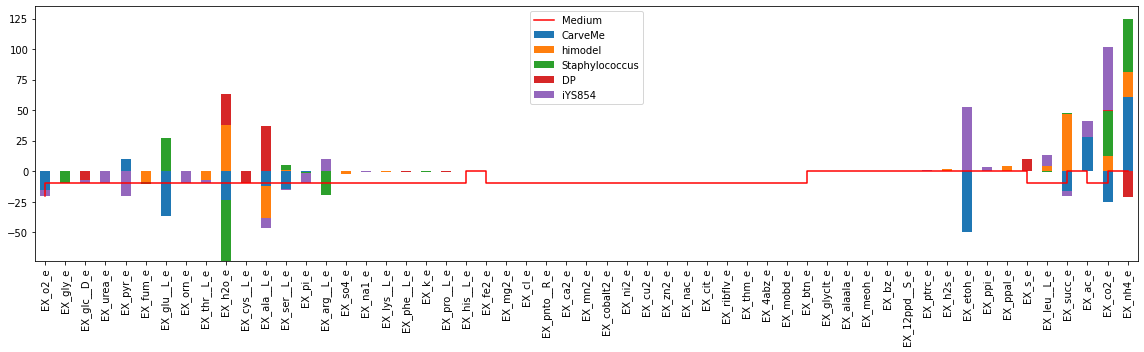

In [29]:
summary = model.summary(cooperative_tradeoff=0.4)
f = plot_community_summary(model, summary)

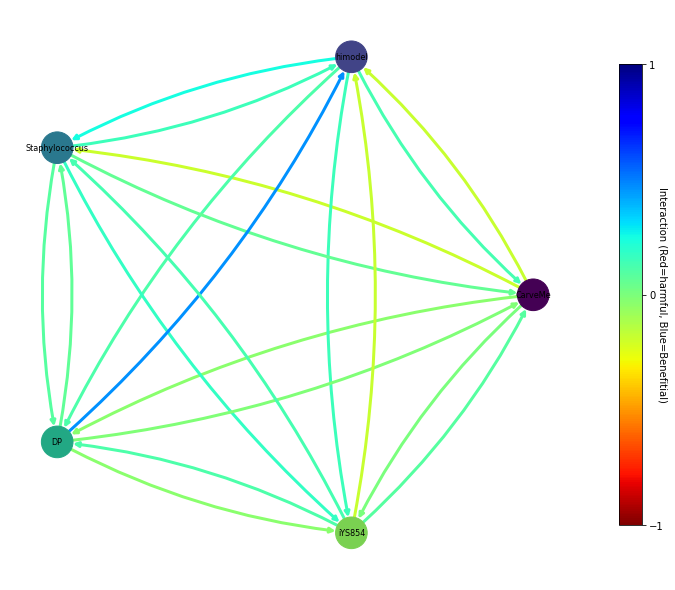

In [30]:
f = plot_species_interaction(model, summary)

Now where each model obtains the same growth, we can see some competitive interactions.

## COOPM

Last but not least we may are intersted at different medias. The COOPM (cooperation inducing medium) is made such that all members in the community survive with atleast 10 % of their maximum growth rate. But also tries to minimize the number of metabolites within the medium. This induces a large number of cooperations, within the community as we see here:

Objective:  0.5865489805634342
CarveMe_SNM_gapfilled_model :  0.30205729781699103  with weights  1.0
himodel :  0.22957169713417555  with weights  1.0
Staphylococcus_epidermidis_ATCC_12228 :  0.001155296990016737  with weights  1.0
DP_83VPs_KB5 :  0.04203370901034009  with weights  1.0
iYS854 :  0.011730979611910877  with weights  1.0


c:\users\manug\desktop\ncmw projects\ncmw\ncmw\community\community_analysis.py:95: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(df.columns[-1], 1)


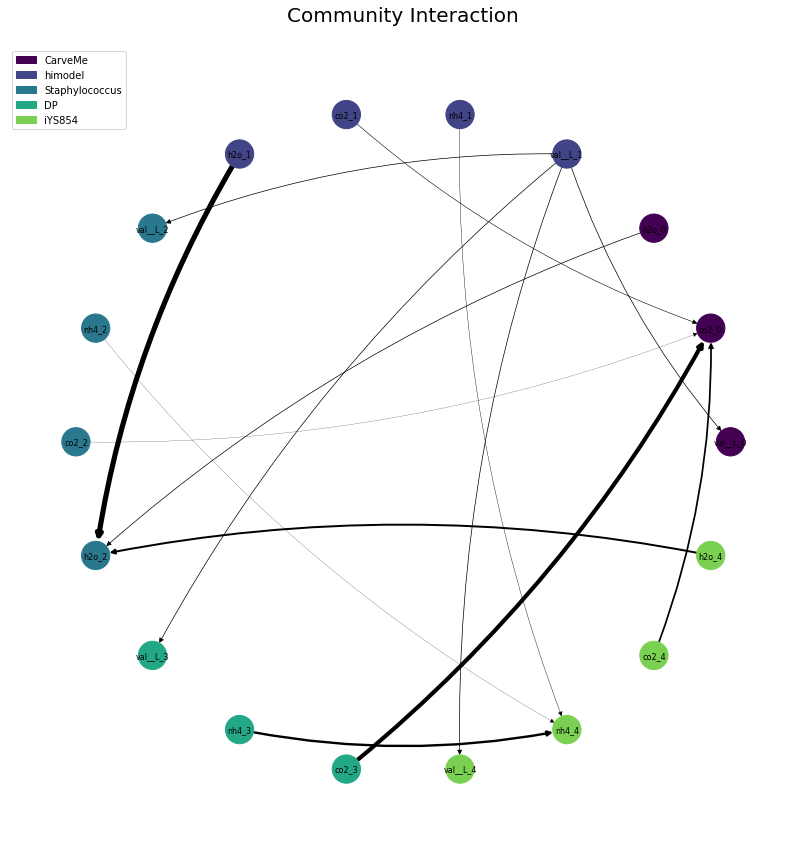

In [31]:
coopm = model.compute_COOPM(model.slim_optimize())
model.medium = coopm 
fig = plot_community_interaction(model, model.summary())

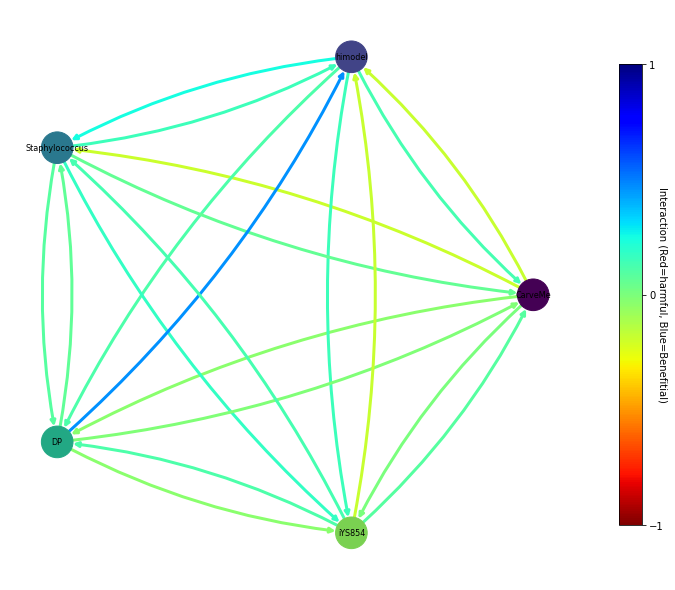

In [32]:
f = plot_species_interaction(model, summary)

Thats now much less crowded. We found a very small medium on which all community members can have growth!

In [33]:
coopm

{'EX_cl_e': 0.00526440387435687,
 'EX_k_e': 0.10703127131520629,
 'EX_pro__L_e': 10.0,
 'EX_ca2_e': 0.004921269850081437,
 'EX_mg2_e': 0.008260245659765051,
 'EX_mn2_e': 0.0019649599149054796,
 'EX_cobalt2_e': 0.0015384936282006924,
 'EX_zn2_e': 0.0015218750158314581,
 'EX_cu2_e': 0.0017507825880713728,
 'EX_o2_e': 20.0,
 'EX_fe2_e': 0.011078881751181213,
 'EX_mobd_e': 8.21168572830355e-08,
 'EX_so4_e': 0.17226740763443973,
 'EX_nac_e': 0.0010105774709678883,
 'EX_thm_e': 6.413671936411129e-05,
 'EX_na1_e': 0.027147879335757352,
 'EX_ni2_e': 0.0014919944509071798}